# Warning

В данному ноутбуке используется плохой тестовый файл в качестве примера

In [245]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder as LE
from scipy import stats

In [227]:
fpath = "/usr/local/data/transactions.txt" #"example.txt"
df = pd.read_csv(fpath, header=None, sep =",")

In [228]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
0    27 non-null int64
1    27 non-null object
2    27 non-null int64
3    27 non-null object
dtypes: int64(2), object(2)
memory usage: 3.8 KB


# Находим число клиентов и средний объем транзакций каждого сегмента

In [216]:
af_num, r_num = 0, 0
af_sum, r_sum =0, 0
df_chunk = pd.read_csv(fpath, usecols=[2,3],
                       chunksize=5, header=None)

for chunk in df_chunk:
    c_v = chunk.values

    af_num += len(c_v[c_v==['AF']])
    r_num += len(c_v[c_v==['R']])

    for _, i in enumerate(c_v):
        if(['R'] in i):
            r_sum += i[0]
        else:
            af_sum += i[0]

In [217]:
print(af_num, r_num, af_sum/af_num, r_sum/r_num)

11 16 38454.545454545456 2581.25


Возможность получения представительной выборки объема транзакций по каждому сегменту:

In [221]:
AF_clients = np.array([])
R_clients = np.array([])

df_chunk = pd.read_csv(fpath, usecols=[2,3],
                       chunksize=50*10**6, header=None)
for chunk in df_chunk:
    c_v = chunk.values

    for _, i in enumerate(c_v):
        if(['R'] in i):
            R_clients = np.append(R_clients, i[0])
        else:
            AF_clients = np.append(AF_clients, i[0])

Оценка выборки

(Начальный файл весил 3.8кб)

In [247]:
sys.getsizeof(AF_clients.astype('int64'))+sys.getsizeof(R_clients.astype('int64'))

408

Как видно на примере, мы можем оставить 10% размера начального текстого файла, сохраняя необходимые нам данные об объеме транзакций конкретного сегмента, при это сохраняя всю возможную выборку

Однако, из оперативной памяти мы можем рассчитывать примерно на 13-14Гб, что много меньше 25Гб, которые в худшем случае могут приходиться на один сегмент

Есть несколько вариантов подхода к решению задач из матстата:

1) Можно из каждого сегмента убрать часть клиентов, рассчитывая, что выборка достаточно представительна и это не окажет сильного влияния на статистические параметры 

2) Можно понизить тип данных с float до int32, перенебрегая дробной частью и выбросами в виде сверхбольших объемов транзакций, а так же рассчитывая, что маловероятно, что все клиенты окажутся в одном сегменте, то есть массивы будут более-менее сбалансированы

In [246]:
sys.getsizeof(AF_clients.astype('int32'))+sys.getsizeof(R_clients.astype('int32'))

300

Предположим, что разобрались с массивыми


# Доверительный интервал 

Проверка на нормальность

Графически

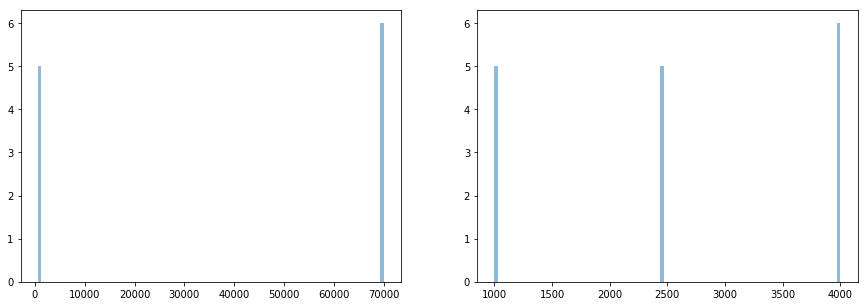

In [248]:
fig = plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
plt.hist(AF_clients, 100, alpha=0.5)

ax2 = plt.subplot(122)
plt.hist(R_clients, 100, alpha=0.5)

plt.show()

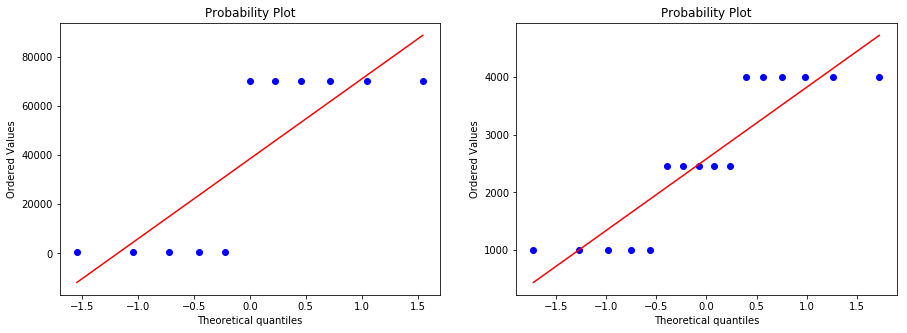

In [249]:
fig = plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
stats.probplot(AF_clients, dist = "norm", plot = plt)

ax2 = plt.subplot(122)
stats.probplot(R_clients, dist = "norm", plot = plt)

plt.show()

In [256]:
alpha = 0.9
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

TypeError: unsupported operand type(s) for *: 'module' and 'float'

# Проверка статистической гипотезы

Гипотезы:
    
Н0: средние объемы транзвкций сегментов равны

Н1: средние объемы транзвкций сегментов не равны

Если данные имеют нормальное распределение, то в теории можно использовать критерий Стьюдента

Проверим равенство дисперсий:

In [252]:
print('Сравнение дисперсий для применения дисперсионного анализа\n', AF_clients.std()**2, R_clients.std()**2)

Сравнение дисперсий для применения дисперсионного анализа
 1194138842.9752066 1540773.4374999998


Критерий Стьюдента

Выборки несвязанные, критерий значимости = 0.1

In [254]:
t_stat = stats.ttest_ind(AF_clients, R_clients)
t_stat

Ttest_indResult(statistic=3.9919475058485867, pvalue=0.0005057951153643918)

Из этого следует, что вероятность ошибочно отвергнуть нулевую гипотезу мала

Но можно воспользоваться и непараметрическими критериями, тот же критерий Манна-Уитни, но тогда не должно быть повторяющихся признаков

Таким образом, выбор критерия должен быть обоснован анализом данных в рамках задачи

In [ ]:
df_kek = pd.read_csv(fpath, usecols=[2,3], header=None, sep =",")

In [114]:
df_kek = pd.read_csv(fpath, usecols=[2,3], header=None, sep =",")
le = LE()
le.fit(df_kek[3])
df_kek['class'] = le.transform(df_kek[3])
df_kek['class'] = df_kek['class'].astype(np.int8)
df_kek.drop(columns=[3], inplace=True)

In [83]:
df_kek['class']

0    1
1    0
2    1
3    1
4    0
Name: class, dtype: int8

In [115]:
df_kek.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
2        25 non-null int64
class    25 non-null int8
dtypes: int64(1), int8(1)
memory usage: 305.0 bytes


In [36]:
df_kek.memory_usage(deep=True)

Index     80
2         40
3        304
dtype: int64

In [23]:
df_kek

,2,3
0,1000,R
1,600,AF
2,2460,R
3,4000,R
4,70000,AF


In [16]:
[0,1,2,3]\[3]

SyntaxError: unexpected character after line continuation character (<ipython-input-16-106e7bbdb2b3>, line 1)

In [41]:
sys.getsizeof(df[2])

144

In [15]:
df[0].info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
0    5 non-null int64
1    5 non-null object
2    5 non-null int64
3    5 non-null object
dtypes: int64(2), object(2)
memory usage: 794.0 bytes


In [86]:
class_clients = {"0" : [0, "wq"], "1" : [0, "wd"]}

In [ ]:
class_clients

In [108]:
df_kek[3].value_counts().reset_index()

,index,3
0,R,3
1,AF,2


In [106]:
df_kek[3].value_counts()

2

In [88]:
for i in class_clients:
    class_clients['0'][0] = len(df_kek['class'][df_kek['class']==i])

0
1


In [98]:
df_kek['class'][df_kek['class']==1]

0    1
2    1
3    1
Name: class, dtype: int8

In [92]:
class_clients['0'][1]

'wq'